In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')        #pobieranie danych do ścieżki

train_dir = os.path.join(PATH, 'train')             #dane są już podzielone na dwa katalogi, trenujący i walidacyjny
validation_dir = os.path.join(PATH, 'validation')   #teraz tylko chcemy je odpowiednio wczytać

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)  #tworzymy z danych obiekty tf.data.Dataset żeby ułatwić działanie programu

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


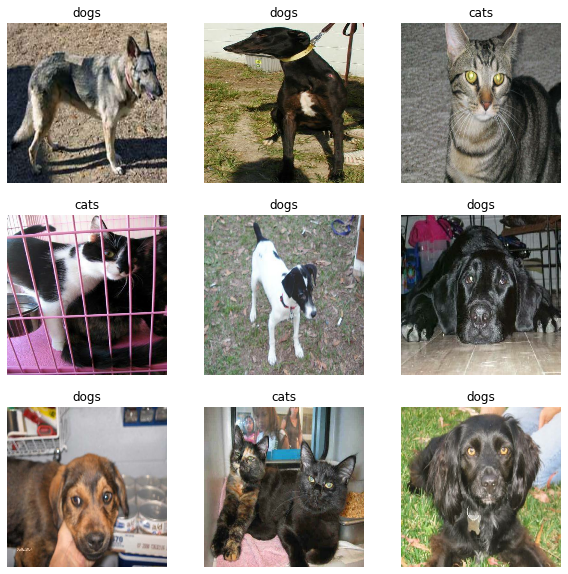

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))                        #wizualizacja przykładowych danych
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset) #dzielenie zbioru walidacyjnego na testowy i walidacyjny
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE                    #automatyczne dostrajanie danych
                                               #dane będą się ładować w trakcie kiedy wcześniejsze będą już przetwarzane
                                               #pozwoli to na szybsze uczenie sieci co jest szczególnie przydatne w uczeniu dużych sieci
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([       
  tf.keras.layers.RandomFlip('horizontal'),           #losowe zmiany położenia obrazu żeby zwiększyć ogólne dopasowanie sieci i przeciwdziałać overfittingowi
  tf.keras.layers.RandomRotation(0.2),
])

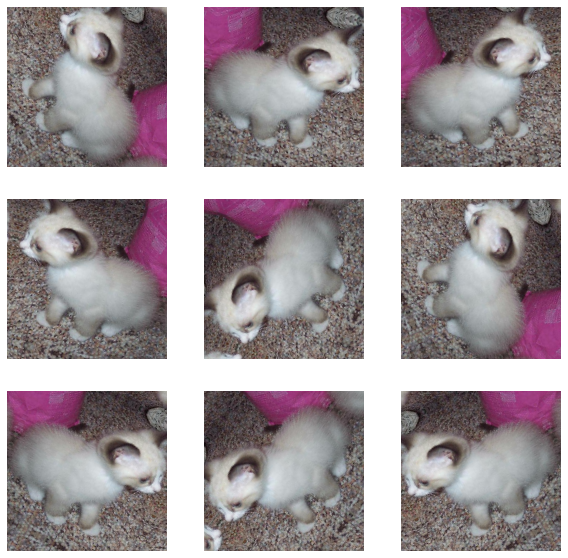

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input #skalowanie wartości pikseli z [0,256] do [-1,1]

In [ ]:

IMG_SHAPE = IMG_SIZE + (3,)                       #tworzymy model bazowy na którym będziemy nadbudowywać sieć, model to MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False                   #ustawiamy model bazowy jaki nietrenowalny, w ten sposób nasza sieć nie będzie 
                                               #ulepszać tych wag a jedynie naszą nadbudowaną część

In [ ]:
base_model.summary() #architektura modelu bazowego

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)       #tworzenie warstwy które okna 5x5 zamieni na 1x1 poprzez AveragePooling
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)        #tworzenie warstwy wyjściowej która będzie dawać jeden output (czy to jest kot czy nie)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)                                   #złożenie modelu w całość przy użyciu wcześniej zdefiniowanych warstw
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001                   
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),    #ustawienie learning rate, optimizera i funkcji straty
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)          #wstępna ewaluacja modelu

26/26 [==============================] - 14s 471ms/step - loss: 0.9130 - accuracy: 0.3700


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.91
initial accuracy: 0.37


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)          #uczenie sieci (ok 10 min)

Epoch 1/10
63/63 [==============================] - 50s 745ms/step - loss: 0.7400 - accuracy: 0.5430 - val_loss: 0.6154 - val_accuracy: 0.6361
Epoch 2/10
63/63 [==============================] - 47s 742ms/step - loss: 0.5395 - accuracy: 0.7150 - val_loss: 0.4418 - val_accuracy: 0.7809
Epoch 3/10
63/63 [==============================] - 47s 744ms/step - loss: 0.4282 - accuracy: 0.7865 - val_loss: 0.3327 - val_accuracy: 0.8552
Epoch 4/10
63/63 [==============================] - 48s 757ms/step - loss: 0.3633 - accuracy: 0.8360 - val_loss: 0.2635 - val_accuracy: 0.8948
Epoch 5/10
63/63 [==============================] - 50s 786ms/step - loss: 0.3085 - accuracy: 0.8585 - val_loss: 0.2275 - val_accuracy: 0.9097
Epoch 6/10
63/63 [==============================] - 48s 759ms/step - loss: 0.2834 - accuracy: 0.8755 - val_loss: 0.1941 - val_accuracy: 0.9307
Epoch 7/10
63/63 [==============================] - 47s 740ms/step - loss: 0.2648 - accuracy: 0.8850 - val_loss: 0.1727 - val_accuracy: 0.9332

In [ ]:
base_model.trainable = True                   #teraz odblokujemy możliwość zmiany wartości wag dla wyższych warstw naszej sieci bazowej
                                              #w ten sposób lepiej dostosujemy naszą sieć bazową do zadania do którego chcemy ją wyznaczyć 

print("Ilość warstw: ", len(base_model.layers))

fine_tune_at = 120                            #wybieramy, że 100 pierwszych warstw NIE będzie podlegało treningowi

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Ilość warstw:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),   #w związku ze zmianą specyfiki działania sieci zmniejszamy learning rate
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,                        #ponownie uczymy model, tym razem z dostosowaniem warstw modelu bazowego
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 70s 1s/step - loss: 0.1617 - accuracy: 0.9305 - val_loss: 0.0592 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 63s 997ms/step - loss: 0.1173 - accuracy: 0.9445 - val_loss: 0.0474 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 63s 998ms/step - loss: 0.1079 - accuracy: 0.9575 - val_loss: 0.0504 - val_accuracy: 0.9765
Epoch 13/20
63/63 [==============================] - 62s 989ms/step - loss: 0.1108 - accuracy: 0.9610 - val_loss: 0.0446 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 62s 981ms/step - loss: 0.0967 - accuracy: 0.9605 - val_loss: 0.0427 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 62s 985ms/step - loss: 0.0973 - accuracy: 0.9540 - val_loss: 0.0341 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 62s 989ms/step - loss: 0.0785 - accuracy: 0.9695 - val_loss: 0.0414 - val_accuracy: 0.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']                 #obliczamy dokładność i straty sieci i rzucamy je na wykres
val_loss += history_fine.history['val_loss']

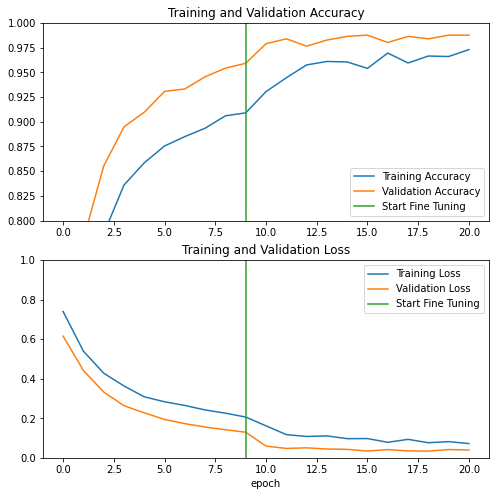

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
                                                                                #wykresy funkcji straty i dokładności przed i po uczeniu warstw modelu bazowego
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Wnioski: 
Fine tuning (uczenie wyższych warstw modelu bazowgo) jest bardzo przydatne i daje lepsze wyniki niż samo nadbudowywanie nad bardziej ogólny model. Dostosowanie wyższych warstw modelu bazowego może być kluczowe dla dokładności działania konkretnego zadania.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)                      

6/6 [==============================] - 5s 761ms/step - loss: 0.0290 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


ValueError: ignored

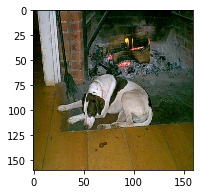

In [ ]:
#class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))                        #wizualizacja przykładowych danych
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.imshow(images[i].numpy().astype("uint8"))
    wynik = model.predict(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")
